In [1]:
# Jared Novoa
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt

In [2]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/ # get all data to our HDFS

In [3]:
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/11 05:18:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Q1 how many banks contain the word "first" in their name, ignoring case? Use an RDD to answer
banks_df = (spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv"))
banks_df.rdd.filter(lambda row : "first" in row["respondent_name"].lower() ).count()


525

In [5]:
#Q2 how many banks contain the word "first" in their name, ignoring case? Use a DataFrame to answer.
banks_df.filter("""
LOWER(respondent_name) LIKE "%first%"    
""").count()

525

In [6]:
banks_df.write.saveAsTable("banks", mode="overwrite")

23/11/11 05:19:29 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/11 05:19:29 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/11 05:19:33 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/11 05:19:33 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.19.0.4
23/11/11 05:19:34 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/11 05:19:39 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/11/11 05:19:39 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/11/11 05:19:39 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/11 05:19:39 W

In [7]:
#Q3: how many banks contain the word "first" in their name, ignoring case? Use Spark SQL to answer
spark.sql("""
    SELECT *
    FROM banks
    WHERE LOWER(respondent_name) LIKE "%first%"
""").count()

525

In [8]:
loans_df = (spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("hdfs://nn:9000/hdma-wi-2021.csv"))
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode = "overwrite")

23/11/11 05:19:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
tables_to_make = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
 "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]
for table in tables_to_make:
    (spark.read
     .format("csv")
     .option("header", True)
     .option("inferSchema", True)
     .load(f"hdfs://nn:9000/{table}.csv")
     .createOrReplaceTempView(table)
    )

In [10]:
#Q4: what tables are in our warehouse?
# https://stackoverflow.com/questions/68968116/pyspark-df-to-dict-one-column-as-key-the-other-as-value
row_dict = spark.sql("SHOW TABLES").rdd.map(lambda row: row.asDict()).collect()
table_bool_dict = {d["tableName"]: d["isTemporary"] for d in row_dict}
table_bool_dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [11]:
#Q5: how many loan applications has the bank "University of Wisconsin Credit Union" received in 2020 in this dataset?
spark.sql("""
    SELECT loans.lei, banks.respondent_name AS name
    FROM loans
    INNER JOIN banks
    ON loans.lei = banks.lei_2020
""").where("name == 'University of Wisconsin Credit Union'").count()

19739

In [12]:
#Q6: What does .explain("formatted") tell us about how spark executes Q5?
spark.sql("""
    SELECT loans.lei, banks.respondent_name AS name
    FROM loans
    INNER JOIN banks
    ON loans.lei = banks.lei_2020
""").where("name == 'University of Wisconsin Credit Union'").explain("formatted")

# Here, the banks data is going through the BroadcastExchange step. This would suggest
# that the banks table is smaller than the loans table as Spark is sending it to all
# executor nodes. The plan does not involve HashAggregates. The innerjoin causes a
# BroadcastHashJoin because the worker nodes need to compare the lei from different
# tables in this query. 

== Physical Plan ==
AdaptiveSparkPlan (8)
+- Project (7)
   +- BroadcastHashJoin Inner BuildRight (6)
      :- Filter (2)
      :  +- Scan parquet spark_catalog.default.loans (1)
      +- BroadcastExchange (5)
         +- Filter (4)
            +- Scan parquet spark_catalog.default.banks (3)


(1) Scan parquet spark_catalog.default.loans
Output [1]: [lei#998]
Batched: true
Bucketed: false (bucket column(s) not read)
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
PushedFilters: [IsNotNull(lei)]
ReadSchema: struct<lei:string>

(2) Filter
Input [1]: [lei#998]
Condition : isnotnull(lei#998)

(3) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#64, lei_2020#68]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(4) Filter
Input 

In [13]:
#Q7 What are the average interest rates for Wells Fargo applications for the ten counties where Wells Fargo receives the most applications
county_average_df = spark.sql("""
    SELECT 
        loans.county_code,
        counties.NAME,
        COUNT(*) AS loan_count,
        AVG(loans.interest_rate) AS average_interest_rate 
    FROM loans
    INNER JOIN counties
    ON loans.county_code = counties.STATE*1000 + counties.COUNTY
    INNER JOIN banks
    ON loans.lei = banks.lei_2020
    WHERE LOWER(banks.respondent_name) LIKE "%wells fargo%"
    GROUP BY counties.NAME, loans.county_code
    """)
top_10_counties = county_average_df.rdd.sortBy(lambda x:x[2], ascending=False).map(lambda row: row.asDict()).take(10)
county_interest_rate_dict = {d["NAME"]: d["average_interest_rate"] for d in top_10_counties}
county_interest_rate_dict

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

<BarContainer object of 10 artists>

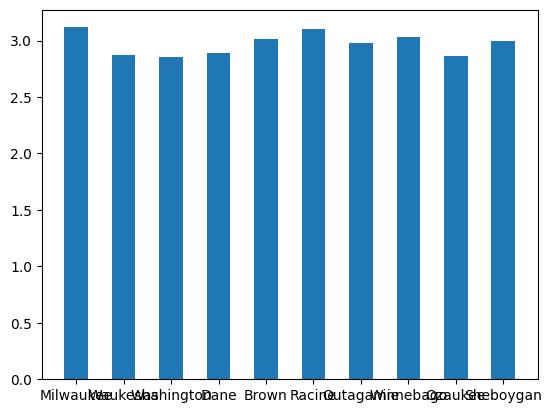

In [14]:
plt.bar(list(county_interest_rate_dict.keys()), list(county_interest_rate_dict.values()), width = 0.5)

In [15]:
#Q8: when computing a MEAN aggregate per group of loans, under what situation (when) do we require network I/O between the partial_mean and mean operations?
# spark.sql("""
#     SELECT 
#         COUNT(DISTINCT derived_dwelling_category) as living_categories,
#         county_code
#     FROM loans
#     GROUP BY county_code
#     LIMIT 10
# """).explain("formatted")

# spark.sql("""
#     SELECT 
#         COUNT(DISTINCT county_code),
#         derived_dwelling_category as living_categories
#     FROM loans
#     GROUP BY living_categories
# """).explain("formatted")

# here, the second query requires some network trasnfer. The first doesn't require it because we are grouping by county_code. When
# we loaded the data into our warehouse, we specified to bucket by county_code. this helps us optimize queries when we are grouping by 
# county code because similar counties are bucketed together, meaning less network I/O is needed when doing a group by on county_code

In [16]:
df = spark.sql("""
    SELECT loan_amount, income, interest_rate, action_taken as approval
    FROM loans
""")
# action_taken is 1 if approved -> we want to encode 1 to be a 1 and any other number to be a 0 for rejected
# also want to cast loan_amount, income, and interest_rate to a double
# https://sparkbyexamples.com/spark/spark-case-when-otherwise-example/
# https://sparkbyexamples.com/pyspark/pyspark-convert-string-type-to-double-type-float-type/
df = df.withColumn("approval", when(col("approval")==1,1.0).otherwise(0.0)).withColumn("loan_amount", col("loan_amount").cast("double")).withColumn("income", col("income").cast("double")).withColumn("interest_rate", col("interest_rate").cast("double")).fillna(0.0)  
# deterministic split
train, test = df.randomSplit([0.8, 0.2], seed=41) 
train.persist()

DataFrame[loan_amount: double, income: double, interest_rate: double, approval: double]

In [17]:
#Q9: How many loans are approved (approval = 1) in the train DataFrame?
train.filter(col("approval") == 1).count()

242868

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.pipeline import Pipeline, PipelineModel


In [19]:
#Q10: What is the accuracy of the decision tree classifier of depth 5 on the test dataset?
va = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")
dt = DecisionTreeClassifier(featuresCol="features", labelCol="approval", maxDepth=5)

pipeline = Pipeline(stages=[va, dt])

model = pipeline.fit(train)

predictions = model.transform(test)
# predictions.printSchema()
accuracy = predictions.filter(predictions["approval"] == predictions["prediction"]).count() / predictions.count()
accuracy

0.8940103963757389